# Cell 1: Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Make plots look nice
plt.style.use('ggplot')
print("Libraries Loaded!")

Libraries Loaded!


# Cell 2: Data Loading & Basic Cleaning


In [2]:
# Load Data
df = pd.read_csv("AB_NYC_2019.csv")

# 1. Basic Cleaning
# Drop rows where price is 0 (errors) or unreasonably high (outliers > $500 for this project)
df = df[(df['price'] > 0) & (df['price'] < 500)]

# Drop missing values in critical columns
df.dropna(subset=['latitude', 'longitude', 'neighbourhood_group', 'room_type'], inplace=True)

print(f"Data Cleaned. Rows remaining: {df.shape[0]}")
df.head()

Data Cleaned. Rows remaining: 47649


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Cell 3: Exploratory Visualization (Boxplot)



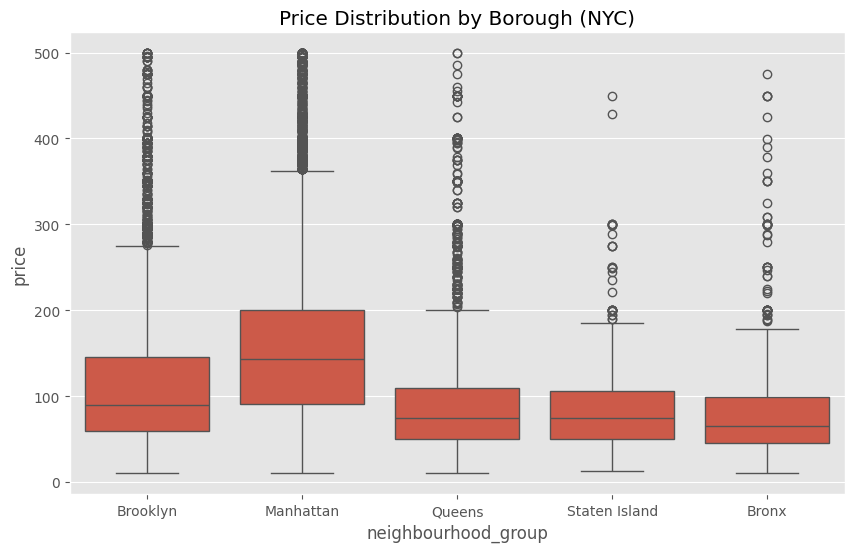

In [3]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title("Price Distribution by Borough (NYC)")
plt.show()

# Cell 4: Geospatial Map Generation


In [4]:
# 1. Create a base map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# 2. Add a Heatmap Layer (Shows where the listings are concentrated)
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data, radius=15).add_to(nyc_map)

# 3. Add Top 100 Most Expensive Listings as Red Dots
expensive_listings = df.sort_values('price', ascending=False).head(100)

for index, row in expensive_listings.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        popup=f"${row['price']}: {row['name']}"
    ).add_to(nyc_map)

# 4. Save the map
nyc_map.save("nyc_airbnb_map.html")
print("Map saved as 'nyc_airbnb_map.html'.")

Map saved as 'nyc_airbnb_map.html'.


# Cell 5: Data Processing & Encoding


In [5]:
# Create a copy for modeling
model_df = df.copy()

# Select features we care about
features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'neighbourhood_group', 'room_type']
model_df = model_df[features + ['price']]

# "One-Hot Encode" the categorical text columns
model_df = pd.get_dummies(model_df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Define X (Inputs) and y (Target)
X = model_df.drop('price', axis=1)
y = model_df['price']

print("Data processed .")
X.head()

Data processed .


,latitude,longitude,minimum_nights,number_of_reviews,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,1,9,True,False,False,False,True,False
1,40.75362,-73.98377,1,45,False,True,False,False,False,False
2,40.80902,-73.94190,3,0,False,True,False,False,True,False
3,40.68514,-73.95976,1,270,True,False,False,False,False,False
4,40.79851,-73.94399,10,9,False,True,False,False,False,False


# Cell 6: Random Forest Training (Baseline)


In [6]:
# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train 
rf_model.fit(X_train, y_train)
print("Training Complete!")

Training Complete!


# Cell 7: Baseline Evaluation & Prediction Function


In [7]:
# 1. Evaluate
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Model Performance:")
print(f"Average Error (MAE): ${mae:.2f}")
print(f"R² Score: {r2:.2f}")

# 2. Interactive Prediction Function
def predict_price(lat, lon, nights, reviews, borough, room_type):
    # Create a DataFrame with the same columns as X_train
    input_data = pd.DataFrame(0, index=[0], columns=X_train.columns)
    
    # Fill numeric
    input_data['latitude'] = lat
    input_data['longitude'] = lon
    input_data['minimum_nights'] = nights
    input_data['number_of_reviews'] = reviews
    
    # Fill categorical (One-hot logic)
    if f"neighbourhood_group_{borough}" in input_data.columns:
        input_data[f"neighbourhood_group_{borough}"] = 1
    if f"room_type_{room_type}" in input_data.columns:
        input_data[f"room_type_{room_type}"] = 1
        
    price = rf_model.predict(input_data)[0]
    return price

# --- TEST IT HERE ---
# Change these values!
my_lat = 40.7128
my_lon = -74.0060
my_nights = 2
my_reviews = 10
my_borough = "Manhattan" # Options: Brooklyn, Queens, Staten Island, Bronx
my_room = "Private room" # Options: Shared room, Entire home/apt

predicted_price = predict_price(my_lat, my_lon, my_nights, my_reviews, my_borough, my_room)
print(f"\nRecommended Price: ${predicted_price:.2f} per night")

Model Performance:
Average Error (MAE): $42.04
R² Score: 0.46

Recommended Price: $119.64 per night


# Cell 8: Feature Engineering & XGBoost (Advanced Model)


In [8]:
# 1. Feature Engineering: Distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    return 6371 * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

df['dist_center'] = haversine(df['latitude'], df['longitude'], 40.7580, -73.9855)

# 2. Feature Engineering: Text
keywords = ['luxury', 'view', 'private', 'quiet', 'subway']
for w in keywords:
    df[f'txt_{w}'] = df['name'].str.lower().str.contains(w, na=False).astype(int)

# 3. Handle Missing Values smartly (instead of dropping)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# 4. Prepare X and y (with Log Transform)
model_df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Drop non-numeric columns we don't need anymore
cols_to_drop = ['id', 'name', 'host_name', 'last_review', 'neighbourhood', 'price']
X = model_df.drop(columns=cols_to_drop)
y = np.log1p(model_df['price']) # LOG TRANSFORM

# 5. Train XGBoost
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05)
model.fit(X_train, y_train)

# 6. Evaluate (Convert back from Log)
preds_log = model.predict(X_test)
preds_real = np.expm1(preds_log)
y_test_real = np.expm1(y_test)

print("MAE:", mean_absolute_error(y_test_real, preds_real))

MAE: 36.30212961058802


# Cell 9: Final Dashboard & Results


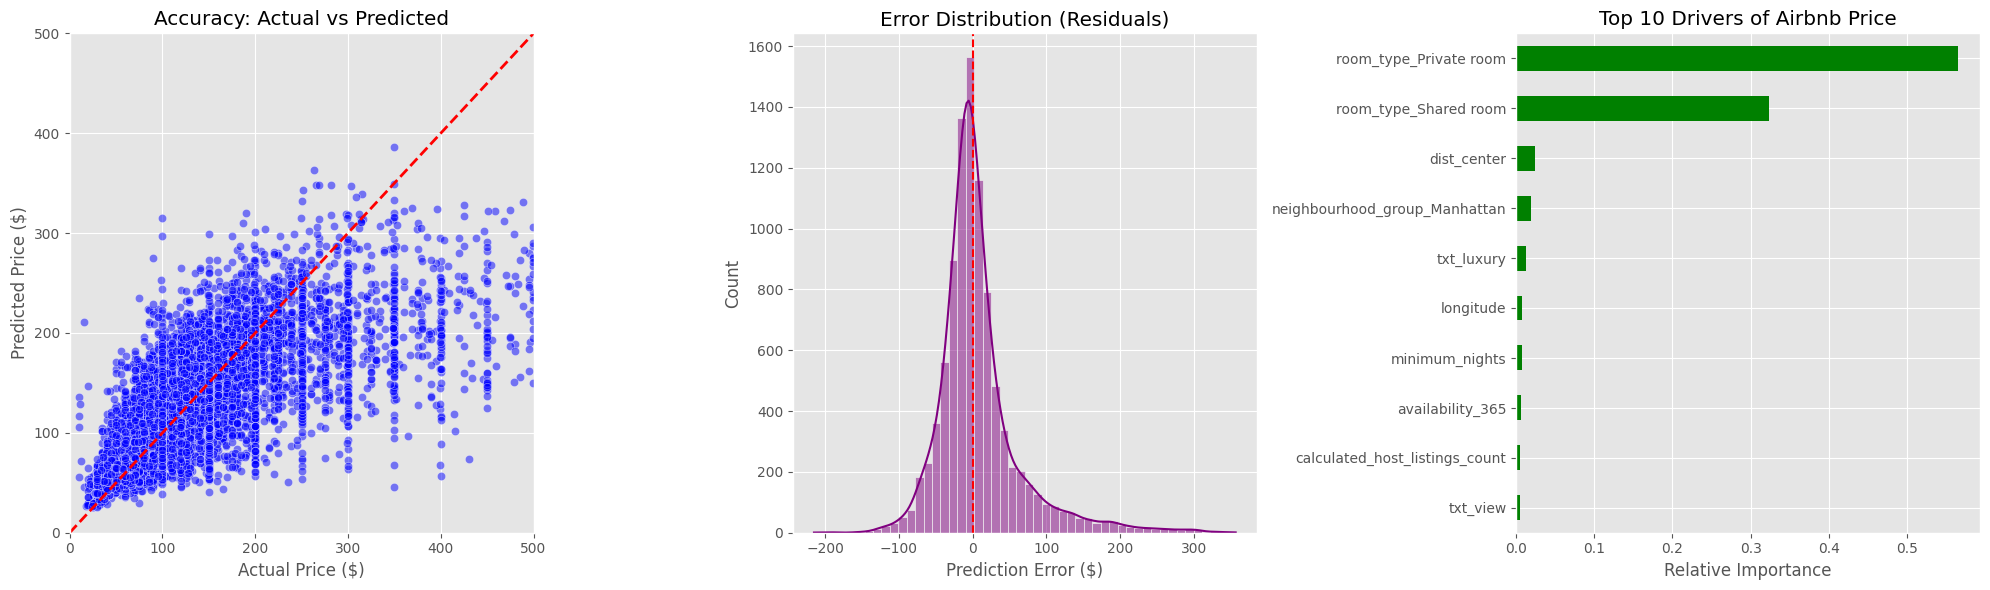

--- FINAL RESULTS SUMMARY ---
1. Model Accuracy (MAE): $36.30
   (On average, our prediction is off by just $36.30)
2. Most Important Factor: room_type_Private room
3. Price Correlation: 0.75 (Closer to 1.0 is better)


In [9]:

# Set the style
plt.style.use('ggplot')

# 1. Create a "Results DataFrame" for easy plotting
results_df = pd.DataFrame({
    'Actual Price': y_test_real,
    'Predicted Price': preds_real
})
results_df['Error'] = results_df['Actual Price'] - results_df['Predicted Price']

# --- CREATE DASHBOARD ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Actual vs Predicted Scatter Plot
# A perfect model would have all dots on the red diagonal line.
sns.scatterplot(x='Actual Price', y='Predicted Price', data=results_df, alpha=0.5, ax=axes[0], color='blue')
axes[0].plot([0, 500], [0, 500], color='red', linestyle='--', linewidth=2) # Diagonal line
axes[0].set_title('Accuracy: Actual vs Predicted')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_xlim(0, 500)
axes[0].set_ylim(0, 500)

# Plot 2: Error Distribution (Residuals)
# We want this to look like a "Bell Curve" centered at 0.
sns.histplot(results_df['Error'], bins=50, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Error Distribution (Residuals)')
axes[1].set_xlabel('Prediction Error ($)')
axes[1].axvline(x=0, color='red', linestyle='--')

# Plot 3: Feature Importance (What drives the price?)
# This tells you which factors matter most.
importances = model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

feat_importances.nlargest(10).sort_values().plot(kind='barh', ax=axes[2], color='green')
axes[2].set_title('Top 10 Drivers of Airbnb Price')
axes[2].set_xlabel('Relative Importance')

plt.tight_layout()
plt.show()

# --- PRINT TEXT SUMMARY ---
print("--- FINAL RESULTS SUMMARY ---")
print(f"1. Model Accuracy (MAE): ${mean_absolute_error(y_test_real, preds_real):.2f}")
print(f"   (On average, our prediction is off by just ${mean_absolute_error(y_test_real, preds_real):.2f})")
print(f"2. Most Important Factor: {feat_importances.nlargest(1).index[0]}")
print(f"3. Price Correlation: {results_df['Actual Price'].corr(results_df['Predicted Price']):.2f} (Closer to 1.0 is better)")